In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import warnings

In [3]:
data_file_formats = [
    ("data/960_seed0_Bo120_qweninst_mistral/", "qwen_instruct_RM-Mistral-7B_prompt_"),
    ("data/Bo120_Llama-3.1-8B-Instruct_RM-Mistral-7B/", "Llama-3.1-8B-Instruct_RM-Mistral-7B_prompt_"),
    ("data/Bo120_Llama-3.2-3B-Instruct_RM-Mistral-7B/", "Llama-3.2-3B-Instruct_RM-Mistral-7B_prompt_"),
    ("data/Bo120_Ministral-8B-Instruct-2410_RM-Mistral-7B/", "Ministral-8B-Instruct-2410_RM-Mistral-7B_prompt_"),
]

In [4]:
data = []
prompt_size = 100
for item in data_file_formats:
    all_x = []
    prefix = item[0] + item[1]
    for i in range(prompt_size):
        index = i
        trajectories = []
        try:
            file_name = prefix + str(index).zfill(4) + ".json"

            import json
            with open(file_name, "r") as f:
                row = json.load(f)
                
                for x in row:
                    trajectories.extend(x["trajectories"])
    #             prompt_data.append(trajectories)
        except:
            pass
        
        x = [y["score"] for y in trajectories]
        all_x.append(x)

    df_real = pd.DataFrame(all_x)
    df_real.shape
    data.append(df_real)

In [19]:
for j in range(len(data)):
    for i in range(100):
        if np.isnan(data[j].iloc[i][0]):
            print(j, i)
            break

1 32
2 35
3 35


In [5]:
def get_cap_value(cdf, cost, estimated_max):
    l = 0
    u = 1e12
    eps = 0.01*len(data)
    for i in range(100):
        m = (l+u)/2
        if 1-cdf(m) < eps:
            u = m
        else:
            l = m

    exp_max = estimated_max
    up = u
    eps = 1e-2
    tot = 0
    tot_density = 0
    while up > eps:
        z = cdf(up*(1-eps))
        dy = cdf(up) - z
        up = up*(1-eps)
        v = up/(up+exp_max)
        tot += v*dy
        tot_density += dy
        if tot-tot_density*v >= cost:
            return v
    return 0

def get_max_value(cdf):
    l = 0
    u = 1e12
    eps = 0.01*len(data)
    for i in range(100):
        m = (l+u)/2
        if 1-cdf(m) < eps:
            u = m
        else:
            l = m
    return u

In [58]:

DISTRIBUTIONS_TO_TEST = {
#     "Gaussian (Normal)": stats.norm,
#     "Exponential": stats.expon,
    "Log-Normal": stats.lognorm,
#     "Gamma": stats.gamma,
#     "Beta": stats.beta,
#     "Weibull": stats.weibull_min, # or stats.weibull_max
    "Pareto": stats.pareto
}

# --- Core Fitting Function ---

def find_best_distribution(data, distributions=DISTRIBUTIONS_TO_TEST, use_aic_bic=True):
    results = []
    best_metric = np.inf
    best_dist_name = None
    best_params = None

    # Ensure data is a numpy array
    data = np.asarray(data)
    n_data = len(data)

    for name, distribution in distributions.items():
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if name == "Log-Normal" or name == "Pareto":
                    params = distribution.fit(data, floc=0)
                else:
                    params = distribution.fit(data)
            ks_stat, ks_p_value = stats.kstest(data, distribution.name, args=params)

            log_likelihood = np.sum(distribution.logpdf(data, *params))
            k_params = len(params) # Number of parameters estimated
            aic = 2 * k_params - 2 * log_likelihood
            bic = k_params * np.log(n_data) - 2 * log_likelihood

            # Store results
            results.append({
                "Distribution": name,
                "Parameters": params,
                "KS Statistic (D)": ks_stat,
                "KS p-value": ks_p_value,
                "Log-Likelihood": log_likelihood,
                "AIC": aic,
                "BIC": bic
            })

            # --- 4. Update Best Fit ---
            current_metric = aic if use_aic_bic else ks_stat # Choose metric for ranking
            if current_metric < best_metric:
                best_metric = current_metric
                best_dist_name = name
                best_params = params

        except Exception as e:
            results.append({
                "Distribution": name,
                "Parameters": None,
                "KS Statistic (D)": np.nan,
                "KS p-value": np.nan,
                "Log-Likelihood": np.nan,
                "AIC": np.nan,
                "BIC": np.nan
            })

    if not results:
         return None, None, pd.DataFrame()

    # Create DataFrame for nice output
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="AIC" if use_aic_bic else "KS Statistic (D)")

    # Determine final best based on the chosen metric after processing all
    if not results_df.empty:
        best_row = results_df.iloc[0]
        final_best_dist_name = best_row["Distribution"]
        final_best_params = best_row["Parameters"]
        best_fit_dist = DISTRIBUTIONS_TO_TEST[final_best_dist_name](*final_best_params)
    else:
        final_best_dist_name = None
        final_best_params = None
        best_fit_dist = None

    return final_best_dist_name, final_best_params, results_df, best_fit_dist

In [112]:
def pandoras_box(data, costs):
    n = np.min([d.shape[0] for d in data])
    max_until = {
        "value": -10,
        "generator": 0,
        "index": 0
    }
    m = len(data)
    
    min_open_count = 10
    
    open_count = [min_open_count for i in range(m)]
    for i in range(m):
        for j in range(min_open_count):
            if data[i][j] > max_until["value"]:
                max_until = {
                    "value": data[i][j],
                    "generator": i,
                    "index": j
                }
    
    global_opt = {
        "value": -10,
        "generator": 0,
        "index": 0
    }
    for i in range(m):
        for j in range(data[i].shape[0]):
            if data[i][j] > global_opt["value"]:
                global_opt = {
                    "value": data[i][j],
                    "generator": i,
                    "index": j
                }
                
    global_max = np.max([np.max(data[i]) for i in range(m)])
    flag = True
    while True:
        cap_values = []
        estimated_max = 0
        
        estimated_dists = []
        
        for i in range(m):
            if open_count[i] == len(data[i]):
                continue
                
            row = data[i]
            
            sample = np.exp(row[:open_count[i]+1])
            eps = 1/n
            multiplier = (1 + max((n/2-open_count[i])/(n/2),0))**3
            sample = sample * multiplier
    
            dist_name, params, _, dist = find_best_distribution(sample)
            
            estimated_dists.append((dist, i))
    
            exp_max = get_max_value(dist.cdf)
            estimated_max = max(exp_max, estimated_max)
#             print("==>", i, exp_max, dist_name, params, np.max(sample), open_count[i])
        
        for dist, i in estimated_dists:
            c = get_cap_value(dist.cdf, costs[i], estimated_max)
            cap_values.append((c, i))
            
        if len(cap_values) == 0:
            break
            
        v = np.exp(max_until["value"])
        v = v/(v + estimated_max)
        cap_values = sorted(cap_values, reverse=True)
        
        if cap_values[0][0] < v:
            break
        else:
            i = cap_values[0][1]
            if data[i][open_count[i]] > max_until["value"]:
                max_until["value"] = data[i][open_count[i]]
                max_until["generator"] = i
                max_until["index"] = open_count[i] 
            
            open_count[i] += 1
            
    return {
        "dist_name": dist_name,
        "exp_score": np.exp(max_until["value"]),
        "open_count": open_count,
        "score": max_until["value"],
        "opt": global_max,
        "exp_opt": np.exp(np.max(global_max)),
        "win_rate": np.exp(max_until["value"])/(np.exp(max_until["value"]) + np.exp(global_max)),
        "max_until": max_until,
        "global_opt": global_opt
    }
    
def call_pandoras_box(data, index, costs):
    x = [np.array(df.iloc[index]) for df in data]
#     for ar in x:
#         np.random.shuffle(ar)
    return pandoras_box(x, costs)

call_pandoras_box(data, 3, [0.002, 0.002, 0.002, 0.002, 0.002])

{'dist_name': 'Log-Normal',
 'exp_score': 2884897.7057018704,
 'open_count': [10, 63, 10, 135],
 'score': 14.875,
 'opt': 14.875,
 'exp_opt': 2884897.7057018704,
 'win_rate': 0.5,
 'max_until': {'value': 14.875, 'generator': 3, 'index': 46},
 'global_opt': {'value': 14.875, 'generator': 3, 'index': 46}}

In [133]:
import tqdm
outs = []
# costs = [0.002, 0.002, 0.002, 0.002, 0.002] # -> good example
# costs = [0.003, 0.003, 0.003, 0.003, 0.003] # -> good example
# costs = [0.005, 0.005, 0.005, 0.005, 0.005] # -> good example
# costs = [0.0015, 0.008, 0.003, 0.008, 0.005] # -> ok example
# costs = [0.0001, 0.01, 0.003, 0.01, 0.005] # -> good example
# costs = [0.0001, 0.02, 0.006, 0.02, 0.005] # -> ok example
# costs = [0.0001, 0.02, 0.006, 0.02, 0.005] # -> ok example
# costs = [0.00005, 0.03, 0.006, 0.03, 0.005] # -> ok example
costs = [0.00001, 0.02, 0.002, 0.02, 0.005] # -> ok example
for i in tqdm.tqdm(range(32)):
    outs.append(call_pandoras_box(data, i, costs))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [04:00<00:00,  7.51s/it]


In [134]:
avg_open_counts = [ int(np.mean([item["open_count"][i] for item in outs])) for i in range(4)]


print(avg_open_counts)

[28, 28, 46, 43]


In [135]:
def performance_avg(index, open_counts):
    x = [np.array(df.iloc[index]) for df in data]
    m = -10
    a = -10
    for i in range(len(x)):
        m = max(m, np.max(x[i]))
        a = max(a, np.max(x[i][:open_counts[i]]))
    return m, a, np.exp(a)/(np.exp(a) + np.exp(m))

In [136]:
win_rates = []
for i in range(32):
    out = performance_avg(i, avg_open_counts)
    
    win_rates.append(out[2])

print(np.mean(win_rates), np.median(win_rates))

0.36642741265573187 0.3593720495166236


In [137]:
win_rates2 = []
for i in range(32):
    win_rates2.append(outs[i]["win_rate"])
print(np.mean(win_rates2), np.median(win_rates2))

0.37704914117202365 0.3776530178433626


In [138]:
for item in outs:
    print(item["win_rate"], item["dist_name"], item["max_until"], item["global_opt"])

0.5 Log-Normal {'value': 8.4375, 'generator': 3, 'index': 21} {'value': 8.4375, 'generator': 3, 'index': 21}
0.43014734858584286 Log-Normal {'value': 7.65625, 'generator': 3, 'index': 70} {'value': 7.9375, 'generator': 3, 'index': 104}
0.2568319913875188 Pareto {'value': 10.4375, 'generator': 3, 'index': 2} {'value': 11.5, 'generator': 3, 'index': 359}
0.5 Log-Normal {'value': 14.875, 'generator': 3, 'index': 46} {'value': 14.875, 'generator': 3, 'index': 46}
0.33458944125318596 Log-Normal {'value': 9.4375, 'generator': 1, 'index': 23} {'value': 10.125, 'generator': 1, 'index': 80}
0.19193278644723683 Pareto {'value': 6.5625, 'generator': 3, 'index': 8} {'value': 8.0, 'generator': 3, 'index': 331}
0.2942149721629888 Log-Normal {'value': 8.0, 'generator': 3, 'index': 15} {'value': 8.875, 'generator': 3, 'index': 121}
0.5 Log-Normal {'value': 11.125, 'generator': 1, 'index': 7} {'value': 11.125, 'generator': 1, 'index': 7}
0.3629692055196168 Log-Normal {'value': 9.625, 'generator': 3, 'i

In [148]:
def plot_graph(df, index):
    vals = np.exp(np.array(df.iloc[index]))

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot histogram using Matplotlib - pass the NumPy array directly
    ax.hist(vals, bins=100, color='skyblue', edgecolor='black')

    # Set the y-axis scale to logarithmic *after* plotting
    ax.set_yscale('log')

    # Add titles and labels
    ax.set_title("Matplotlib Histogram from NumPy Array (Log Y-axis)")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency (log scale)")

    plt.tight_layout() # Adjust layout
    plt.show()

In [149]:
plot_graph(data[4], 0)

IndexError: list index out of range

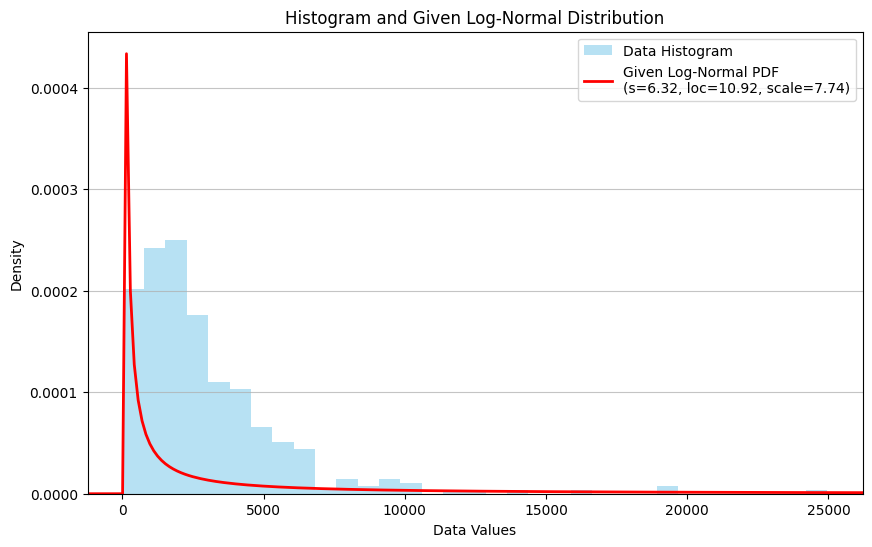

In [142]:
i=0
j=4
params = stats.lognorm.fit(np.exp(np.array(data[i].iloc[j])))
plot_graph_with_params(np.exp(np.array(data[i].iloc[j])), params[0], params[1], params[2])

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import pandas as pd # Import pandas for easy data handling

def plot_graph_with_params(data, s, loc, scale, bins='auto', title='Histogram and Given Log-Normal Distribution'):
    data = np.array(data)

    # --- Plotting ---
    plt.figure(figsize=(10, 6))

    count, bins_edges, _ = plt.hist(data, bins=bins, density=True, alpha=0.6, color='skyblue', label='Data Histogram')
    xmin, xmax = plt.xlim()
    if xmax - xmin < 1e-6:
        xmin = scale / 2 if scale > 0 else -1 # Adjust heuristics as needed
        xmax = scale * 2 if scale > 0 else 1

    x = np.linspace(xmin, xmax, 200) # Use more points for a smoother curve
    pdf = lognorm.pdf(x, s=s, loc=loc, scale=scale)
    plt.plot(x, pdf, 'r', linewidth=2, label=f'Given Log-Normal PDF\n(s={s:.2f}, loc={loc:.2f}, scale={scale:.2f})')

    # --- Customize Plot ---
    plt.xlabel("Data Values")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.xlim(xmin, xmax) # Ensure plot limits match the x-values used for PDF

    # Display the plot
    plt.show()

In [128]:
import numpy as np
import scipy.stats as stats
import warnings
import pandas as pd # For displaying results nicely

# --- Distribution Definitions ---
# Define distributions from scipy.stats we want to test.
# The key is the name we want to use, the value is the scipy.stats object.
DISTRIBUTIONS_TO_TEST = {
#     "Gaussian (Normal)": stats.norm,
    "Exponential": stats.expon,
    "Log-Normal": stats.lognorm,
    "Gamma": stats.gamma,
    "Beta": stats.beta,
    "Weibull": stats.weibull_min, # or stats.weibull_max
}

# --- Core Fitting Function ---

def find_best_distribution(data, distributions=DISTRIBUTIONS_TO_TEST, use_aic_bic=True):
    results = []
    best_metric = np.inf
    best_dist_name = None
    best_params = None

    # Ensure data is a numpy array
    data = np.asarray(data)
    n_data = len(data)

    for name, distribution in distributions.items():
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                params = distribution.fit(data)
            ks_stat, ks_p_value = stats.kstest(data, distribution.name, args=params)

            log_likelihood = np.sum(distribution.logpdf(data, *params))
            k_params = len(params) # Number of parameters estimated
            aic = 2 * k_params - 2 * log_likelihood
            bic = k_params * np.log(n_data) - 2 * log_likelihood

            # Store results
            results.append({
                "Distribution": name,
                "Parameters": params,
                "KS Statistic (D)": ks_stat,
                "KS p-value": ks_p_value,
                "Log-Likelihood": log_likelihood,
                "AIC": aic,
                "BIC": bic
            })

            # --- 4. Update Best Fit ---
            current_metric = aic if use_aic_bic else ks_stat # Choose metric for ranking
            if current_metric < best_metric:
                best_metric = current_metric
                best_dist_name = name
                best_params = params

        except Exception as e:
            results.append({
                "Distribution": name,
                "Parameters": None,
                "KS Statistic (D)": np.nan,
                "KS p-value": np.nan,
                "Log-Likelihood": np.nan,
                "AIC": np.nan,
                "BIC": np.nan
            })

    if not results:
         return None, None, pd.DataFrame()

    # Create DataFrame for nice output
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by="AIC" if use_aic_bic else "KS Statistic (D)")

    # Determine final best based on the chosen metric after processing all
    if not results_df.empty:
        best_row = results_df.iloc[0]
        final_best_dist_name = best_row["Distribution"]
        final_best_params = best_row["Parameters"]
    else:
        final_best_dist_name = None
        final_best_params = None

    return final_best_dist_name, final_best_params, results_df

In [129]:
find_best_distribution(np.exp(np.array(data[0].iloc[0])))

('Beta',
 (0.5140859545900147,
  36.62939072244354,
  0.00298994585631306,
  11357.123474848875),
   Distribution                                         Parameters  \
 3         Beta  (0.5140859545900147, 36.62939072244354, 0.0029...   
 2        Gamma  (0.5196689880017655, 0.00298994585631306, 268....   
 4      Weibull  (0.6137103407306461, 0.00298994585631306, 143....   
 1   Log-Normal  (1.8007826512005423, -0.5185498993633761, 50.6...   
 0  Exponential         (0.0029899458563130603, 156.8153999061991)   
 
    KS Statistic (D)    KS p-value  Log-Likelihood          AIC          BIC  
 3          0.042780  5.114699e-01    -2085.958206  4179.916412  4195.460828  
 2          0.033785  7.927213e-01    -2087.456600  4180.913201  4192.571513  
 4          0.055229  2.141271e-01    -2094.754876  4195.509751  4207.168063  
 1          0.081492  1.581420e-02    -2135.672959  4277.345917  4289.004230  
 0          0.195905  1.399343e-12    -2179.824954  4363.649908  4371.422116  )

In [7]:
def pandoras_box(data, cost):
    n = data.shape[0]
    max_until = 0
    for i in range(30, n):
        prefix = np.exp(data[:i+1])
        max_until = np.max(prefix)
        
        # Being optimistic
        sample = np.copy(prefix)
        eps = 1/n
        multiplier = 1+eps * max(n/2-i, 0)
        sample = sample * multiplier
        
        
        dist_name = "Log-Normal"
        dist_class = stats.lognorm
        params = dist_class.fit(sample, floc=0)
        dist = dist_class(*params)
        
        exp_max = get_max_value(dist.cdf)
        c = get_cap_value(dist.cdf, cost)
        
        v = max_until
        v = v/(v + exp_max)
        if c < v:
            return {
                "dist_name": dist_name,
                "exp_score": max_until,
                "stop_time": i+1, 
                "score": np.max(data[:i+1]),
                "opt": np.max(data),
                "exp_opt": np.exp(np.max(data)),
                "win_rate": max_until/(max_until + np.exp(np.max(data)))
            }
    return {
        "dist_name": dist_name,
        "exp_score": max_until,
        "stop_time": i+1, 
        "score": np.max(data[:i+1]),
        "opt": np.max(data),
        "exp_opt": np.exp(np.max(data)),
        "win_rate": max_until/(max_until + np.exp(np.max(data)))
    }

pandoras_box(df_real.iloc[15], 1e-4)

{'dist_name': 'Log-Normal',
 'exp_score': 76.99573263552006,
 'stop_time': 245,
 'score': 4.34375,
 'opt': 5.375,
 'exp_opt': 215.9398723106141,
 'win_rate': 0.26284183737131667}

In [8]:
np.random.seed(42)
results = []
import tqdm
epoch = 1
for e in range(epoch):
    for i in tqdm.tqdm(range(100)):
        d = np.array(df_real.iloc[i])
#         np.random.shuffle(d)
        out = pandoras_box(d, 1*1e-4)
        results.append(out)
#         print(i, out["dist_name"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.74s/it]


In [9]:
d = np.array([x["stop_time"] for x in results])
np.array(list(range(100)))[d>500]

array([16, 20, 21, 24, 26, 41, 66, 70, 78, 80, 90, 95])

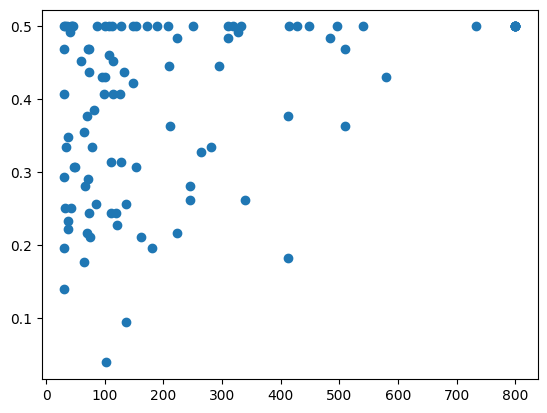

In [10]:
plt.scatter([x["stop_time"] for x in results], [x["win_rate"] for x in results])

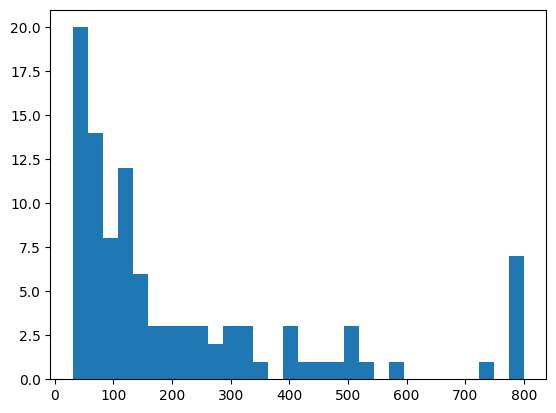

In [11]:
plt.hist([x["stop_time"] for x in results],bins=30)
plt.show()

In [12]:
np.mean([x["win_rate"] for x in results]), np.median([x["win_rate"] for x in results]), np.mean([x["stop_time"] for x in results])

(0.3873819386900119, 0.4301473485858429, 216.84)

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  2.,  2.,  5.,  2.,
         5.,  4.,  2.,  2.,  5.,  1.,  3.,  2.,  2.,  3.,  4.,  1.,  5.,
         4.,  5.,  3., 35.]),
 array([0.03963884, 0.05498421, 0.07032958, 0.08567496, 0.10102033,
        0.1163657 , 0.13171107, 0.14705644, 0.16240182, 0.17774719,
        0.19309256, 0.20843793, 0.2237833 , 0.23912868, 0.25447405,
        0.26981942, 0.28516479, 0.30051016, 0.31585554, 0.33120091,
        0.34654628, 0.36189165, 0.37723702, 0.3925824 , 0.40792777,
        0.42327314, 0.43861851, 0.45396388, 0.46930926, 0.48465463,
        0.5       ]),
 <BarContainer object of 30 artists>)

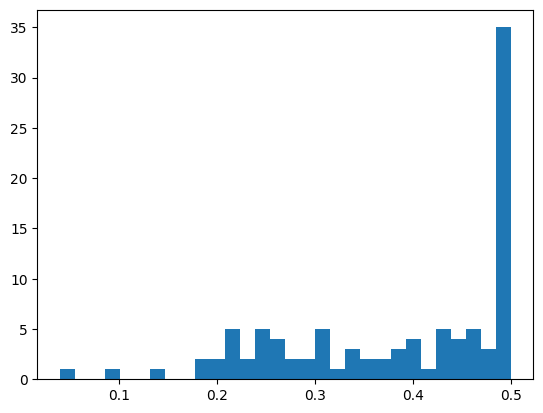

In [13]:
plt.hist([x["win_rate"] for x in results], bins=30)

0.3688778550666523 0.3775406687981454


(array([ 2.,  0.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  6.,  3.,  4.,  0.,
         2.,  2.,  6.,  3.,  3.,  3.,  3.,  5.,  5.,  1.,  2.,  5.,  5.,
         1.,  3.,  3., 24.]),
 array([0.10970577, 0.12271558, 0.13572539, 0.1487352 , 0.161745  ,
        0.17475481, 0.18776462, 0.20077443, 0.21378423, 0.22679404,
        0.23980385, 0.25281366, 0.26582346, 0.27883327, 0.29184308,
        0.30485289, 0.31786269, 0.3308725 , 0.34388231, 0.35689212,
        0.36990192, 0.38291173, 0.39592154, 0.40893135, 0.42194115,
        0.43495096, 0.44796077, 0.46097058, 0.47398038, 0.48699019,
        0.5       ]),
 <BarContainer object of 30 artists>)

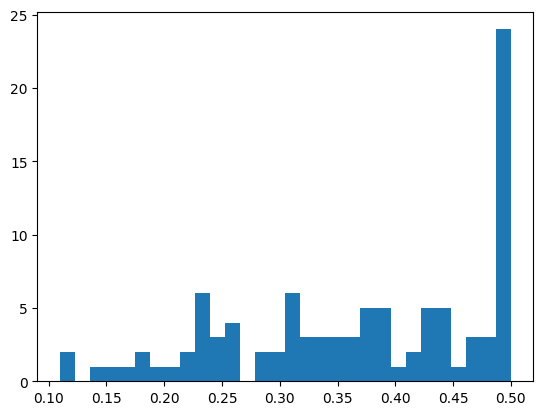

In [14]:
wins = []
for i in range(100):
    d = np.exp(df_real.iloc[i])
    v = np.max(d[:216])
    m = np.max(d)
    wins.append(v/(v+m))
print(np.mean(wins), np.median(wins))
plt.hist(wins, bins=30)

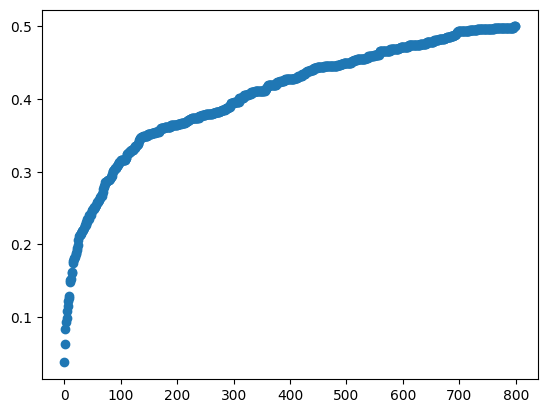

In [15]:
da = np.exp(np.array(df_real))
dm = np.max(da, axis=1)
wrs = []
for i in range(800):
    dv = np.max(da[:, :i+1], axis=1)
    wr = np.mean(dv/(dv+dm))
    
    wrs.append(wr)
plt.scatter(list(range(800)), wrs)